## Import CSV

In [75]:
import pandas
def read_csv(filename,folder):
    folder=folder+"/"+filename+".csv"
    return pandas.read_csv(folder,encoding='ISO-8859-1')

In [76]:
PERD_INDEX="VFINX"
folder='/nfs/Workspace/'
RES_PATH='Result'
data=read_csv(filename="TEST",folder=folder)
data.columns = ( 'DATE','VFINX','^SP500TR','VMOT','RWM','DOG','SH','GLD','USO')
data = data.fillna(method='ffill')
data.head()

,DATE,VFINX,^SP500TR,VMOT,RWM,DOG,SH,GLD,USO
0,2019-08-30,265.023315,5898.229980,23.169899,41.254547,53.297012,26.470428,143.750000,91.680000
1,2019-08-29,264.817871,5893.649902,23.101868,41.165298,53.336716,26.460512,144.119995,94.239998
2,2019-08-28,261.462280,5818.839844,22.963835,41.879318,54.021534,26.807505,145.160004,93.120003
3,2019-08-27,259.750244,5780.790039,22.928339,42.385082,54.587254,26.995869,145.570007,91.360001
4,2019-08-26,260.591614,5799.339844,22.938200,41.780151,54.319283,26.876900,144.190002,89.440002


## Visualize Data

In [3]:
from matplotlib import pyplot
def plot_data(dataset,groups):
    i = 1
    pyplot.figure()
    values = dataset.values
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()

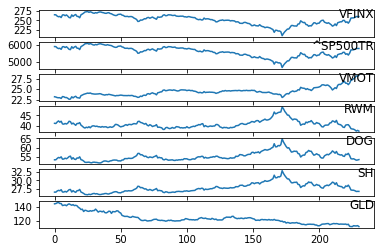

In [4]:
plot_data(data,groups=range(1,len(data.columns)-1))

## Data Summary

In [5]:
data.describe()

,VFINX,^SP500TR,VMOT,RWM,DOG,SH,GLD,USO
count,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,251.565708,5595.327313,24.399518,40.836957,55.181835,27.727219,124.145065,96.759480
std,13.032505,291.042883,1.039845,1.852096,2.302123,1.377240,7.899947,10.610275
min,210.128433,4672.660156,22.548750,37.547550,51.579994,25.667391,112.540001,74.320000
25%,242.829430,5399.270020,23.685060,39.574572,53.567278,26.690384,119.450001,89.440002
50%,252.934784,5626.319824,24.270750,40.498569,54.691292,27.486233,122.010002,94.559998
75%,261.239426,5811.319824,24.756298,41.563396,56.235338,28.528419,126.480003,102.840000
max,273.387878,6083.819824,28.411772,48.979759,64.724808,32.930397,145.570007,128.639999


## Independent and identically distributed (I.I.D.) Testing

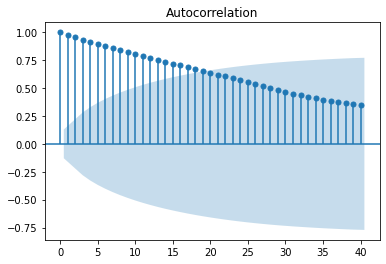

In [6]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
#sm.graphics.tsa.plot_acf(data['vfx'].values, lags=40)
#print(data['VFINX'])
sm.graphics.tsa.plot_acf(data['VFINX'].values, lags=40)
plt.show()

## Histogram

<AxesSubplot:ylabel='Frequency'>

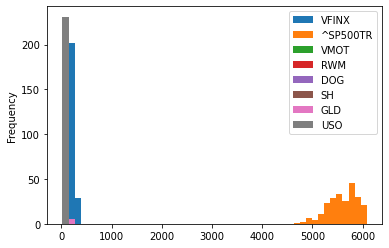

In [7]:
data.plot(kind="hist",bins=50)

## Normal Test 

In [8]:
from scipy import stats
for group in data.columns[1:]:
    print(stats.shapiro(data[group].values))
#print(stats.shapiro(data['spx'].values))

ShapiroResult(statistic=0.9676022529602051, pvalue=4.021859058411792e-05)
ShapiroResult(statistic=0.9679163694381714, pvalue=4.4180611439514905e-05)
ShapiroResult(statistic=0.9188227653503418, pvalue=6.322163903504929e-10)
ShapiroResult(statistic=0.870876669883728, pvalue=4.418732090297195e-13)
ShapiroResult(statistic=0.9269843697547913, pvalue=2.8337743263051607e-09)
ShapiroResult(statistic=0.9390395879745483, pvalue=3.185052577237002e-08)
ShapiroResult(statistic=0.8958984613418579, pvalue=1.482524172868871e-11)
ShapiroResult(statistic=0.9458402991294861, pvalue=1.4186122143655666e-07)


## *** LSTM ***

In [9]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
def Standard_MinMax(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    return sc.fit_transform(data.reshape(-1,1))

In [23]:
#folder="/root/bigdataanalysis/test/"
#data=read_csv(filename="FEAT_DATA",folder=folder)
#data.columns = ( 'DATE','vfx' ,'vix' ,'vbx' ,'rom', 'vmt','rwm','dog','psh', 'spx')
#if not data.get('DATE', None):
del data['DATE']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
data.head()
#print(scaled)

KeyError: 'DATE'

## Series to Supervised

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [25]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.867774,0.868484,0.105944,0.324259,0.130623,0.110565,0.944898,0.319588,0.864526,0.865239,0.094340,0.316452,0.133644,0.109200,0.956100,0.366716
2,0.864526,0.865239,0.094340,0.316452,0.133644,0.109200,0.956100,0.366716,0.811481,0.812225,0.070797,0.378909,0.185742,0.156975,0.987587,0.346097
3,0.811481,0.812225,0.070797,0.378909,0.185742,0.156975,0.987587,0.346097,0.784417,0.785262,0.064743,0.423149,0.228779,0.182910,1.000000,0.313697
4,0.784417,0.785262,0.064743,0.423149,0.228779,0.182910,1.000000,0.313697,0.797718,0.798407,0.066425,0.370235,0.208393,0.166530,0.958220,0.278351
5,0.797718,0.798407,0.066425,0.370235,0.208393,0.166530,0.958220,0.278351,0.752405,0.753260,0.036492,0.411005,0.252941,0.210210,0.957614,0.279823


In [42]:
pred = {PERD_INDEX: 8}
reframed = pandas.concat([reframed.iloc[:,0:8],reframed.iloc[:,pred[PERD_INDEX]]],axis=1)
reframed.head()


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.867774,0.868484,0.105944,0.324259,0.130623,0.110565,0.944898,0.319588,0.864526
2,0.864526,0.865239,0.094340,0.316452,0.133644,0.109200,0.956100,0.366716,0.811481
3,0.811481,0.812225,0.070797,0.378909,0.185742,0.156975,0.987587,0.346097,0.784417
4,0.784417,0.785262,0.064743,0.423149,0.228779,0.182910,1.000000,0.313697,0.797718
5,0.797718,0.798407,0.066425,0.370235,0.208393,0.166530,0.958220,0.278351,0.752405


In [43]:
len(reframed.values)

230

## Data Split

In [54]:
train = reframed.values[:200,:]
test = reframed.values[200:230,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((200, 8), (200,), (30, 8), (30,))

## LSTM

In [16]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

import keras
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


## Training

In [77]:
history = model.fit(train_X, train_y, epochs=1000, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0435 - mae: 0.1780 - mse: 0.0435 - val_loss: 0.0116 - val_mae: 0.0919 - val_mse: 0.0116
Epoch 2/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0433 - mae: 0.1774 - mse: 0.0433 - val_loss: 0.0116 - val_mae: 0.0923 - val_mse: 0.0116
Epoch 3/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0431 - mae: 0.1768 - mse: 0.0431 - val_loss: 0.0117 - val_mae: 0.0927 - val_mse: 0.0117
Epoch 4/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0428 - mae: 0.1763 - mse: 0.0428 - val_loss: 0.0118 - val_mae: 0.0931 - val_mse: 0.0118
Epoch 5/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0426 - mae: 0.1758 - mse: 0.0426 - val_loss: 0.0119 - val_mae: 0.0935 - val_mse: 0.0119
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0424 - mae: 0.1753 - mse: 0.0424 - val_loss: 0.0120 - val_mae: 0.0938 - val_mse: 0.0120
Epoch 7/1000
3/3 [========

## Plot Loss Curve

Populating the interactive namespace from numpy and matplotlib


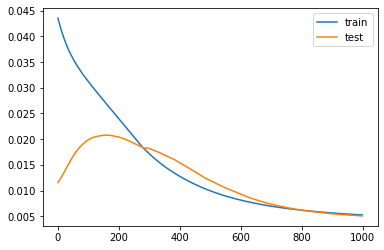

In [79]:
%pylab inline
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predict

In [82]:
yhat = model.predict(test_X)
print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
yhat.shape, test_X.shape

(30, 8)


((30, 1), (30, 8))

## Invert scaling for forecast

In [148]:
pred = {PERD_INDEX: 0}
pred,pred[PERD_INDEX]
test_X

array([[0.7731756 , 0.77228669, 0.30538708, 0.15449976, 0.21339536,
        0.17078463, 0.25340603, 0.53019152],
       [0.77963954, 0.77874227, 0.31110422, 0.13809138, 0.21339536,
        0.16399166, 0.26248854, 0.50662733],
       [0.84828057, 0.84738111, 0.3771933 , 0.07073044, 0.13974179,
        0.10557401, 0.25037829, 0.55670099],
       [0.86674807, 0.8656991 , 0.3876191 , 0.07245723, 0.12997173,
        0.08927109, 0.24553433, 0.52724594],
       [0.82642601, 0.82542028, 0.35516371, 0.13981851, 0.15928277,
        0.12459338, 0.22403876, 0.51988214],
       [0.83504443, 0.83405852, 0.36474889, 0.15622722, 0.140494  ,
        0.11644218, 0.23796546, 0.57879239],
       [0.86644028, 0.86535204, 0.38038825, 0.12254658, 0.11418861,
        0.09062984, 0.26218572, 0.58910162],
       [0.86228521, 0.86127011, 0.38846037, 0.10354718, 0.11944975,
        0.09198859, 0.25098393, 0.58026504],
       [0.85766797, 0.85661449, 0.38341501, 0.11995589, 0.12170464,
        0.0960638 , 0.267332

In [149]:
inv_yhat = concatenate((yhat, numpy.delete(test_X, pred[PERD_INDEX], axis=1)), axis=1)
inv_yhat.shape

(20, 8)

In [150]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape


(20,)

## Invert scaling for actual

In [151]:
real = test_y.reshape((len(test_y), 1))
inv_y = concatenate((real, numpy.delete(test_X, pred[PERD_INDEX], axis=1)), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

(20,)

## RMSE

In [152]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.002


In [153]:
#inv_y = np.cumprod(inv_y+1)
#inv_yhat = np.cumprod(inv_yhat+1)
inv_y,inv_yhat

(array([0.78814173, 0.79085563, 0.79158579, 0.78999156, 0.79033231,
        0.79157363, 0.79140934, 0.79122679, 0.790454  , 0.79051488,
        0.79087995, 0.78942568, 0.78925531, 0.78899362, 0.78935265,
        0.78926746, 0.78937092, 0.78827559, 0.78826954, 0.78769752]),
 array([0.78731323, 0.78725914, 0.78802364, 0.78809332, 0.78770409,
        0.78835752, 0.78882236, 0.78854163, 0.78858979, 0.78865238,
        0.78860121, 0.78870487, 0.78848544, 0.78797152, 0.78788093,
        0.78803682, 0.78832378, 0.78833524, 0.78820976, 0.78862159]))

## Predict vs Real

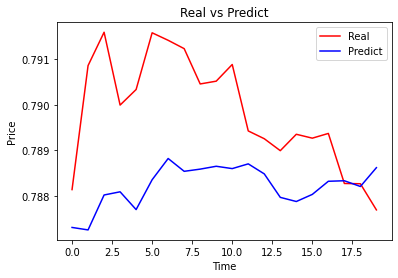

In [154]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(inv_y, color = 'red', label = 'Real')
plt.plot(inv_yhat, color = 'blue', label = 'Predict')
plt.title('Real vs Predict')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## CNN Data Split (same with LSTM)

In [56]:
train = reframed.values[:200,:]
#print(train.shape)
test = reframed.values[200:230,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((200, 8), (200,), (30, 8), (30,))

## CNN Data Split

In [57]:
from keras.layers import Activation, Dense
model = keras.Sequential()
model.add(Dense(5, activation='relu', input_shape=(8,)))
model.add(Dense(5, activation='relu'))
model.add(Dense(1,  activation='sigmoid'))
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae','mse'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


## Training

In [58]:
history = model.fit(train_X, train_y, epochs=100, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/100
3/3 [==============================] - 0s 45ms/step - loss: 0.0727 - mae: 0.2340 - mse: 0.0727 - val_loss: 0.0211 - val_mae: 0.1140 - val_mse: 0.0211
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0724 - mae: 0.2335 - mse: 0.0724 - val_loss: 0.0210 - val_mae: 0.1135 - val_mse: 0.0210
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0722 - mae: 0.2331 - mse: 0.0722 - val_loss: 0.0209 - val_mae: 0.1131 - val_mse: 0.0209
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0720 - mae: 0.2328 - mse: 0.0720 - val_loss: 0.0207 - val_mae: 0.1126 - val_mse: 0.0207
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0718 - mae: 0.2324 - mse: 0.0718 - val_loss: 0.0206 - val_mae: 0.1122 - val_mse: 0.0206
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0716 - mae: 0.2320 - mse: 0.0716 - val_loss: 0.0204 - val_mae: 0.1117 - val_mse: 0.0204
Epoch 7/100
3/3 [================

## Plot Loss Curve

Populating the interactive namespace from numpy and matplotlib


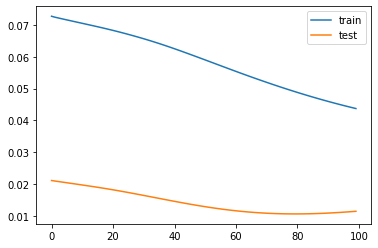

In [60]:
%pylab inline
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predict

In [61]:
yhat = model.predict(test_X)
yhat.shape, test_X.shape

((30, 1), (30, 8))

In [69]:
pred = {PERD_INDEX: 0}
print(test_X.shape)
inv_yhat = concatenate((yhat, numpy.delete(test_X, pred[PERD_INDEX], axis=1)), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape

(30, 8)


(30,)

In [71]:
real = test_y.reshape((len(test_y), 1))
inv_y = concatenate((real, numpy.delete(test_X, pred[PERD_INDEX], axis=1)), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

(30,)

In [72]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.778


In [73]:
#inv_y = np.cumprod(inv_y+1)
#inv_yhat = np.cumprod(inv_yhat+1)
inv_y,inv_yhat

(array([247.93426514, 250.18914795, 250.69020081, 245.48672485,
        243.93534851, 242.57669067, 244.0894928 , 241.53598022,
        238.94392395, 235.23405457, 236.78543091, 240.95782471,
        236.56381226, 244.0894928 , 245.42893982, 246.4888916 ,
        246.57562256, 250.15058899, 250.20840454, 244.93751526,
        246.38290405, 242.91392517, 248.01141357, 256.44287109,
        256.73196411, 256.83798218, 258.25445557, 260.32623291,
        260.14312744, 260.23947144]),
 array([249.09694881, 249.59414196, 249.94516948, 250.04701599,
        249.69950263, 249.59466984, 249.55895136, 249.63146293,
        249.41708416, 249.21825139, 248.74036725, 249.05003177,
        249.3572869 , 248.89824801, 249.7261303 , 250.15673542,
        250.19801925, 250.25905702, 250.71039644, 250.97155274,
        250.37761841, 250.43263837, 250.06642682, 250.73686575,
        251.66835163, 251.69618211, 251.78938273, 252.0132256 ,
        252.42958179, 252.27763213]))

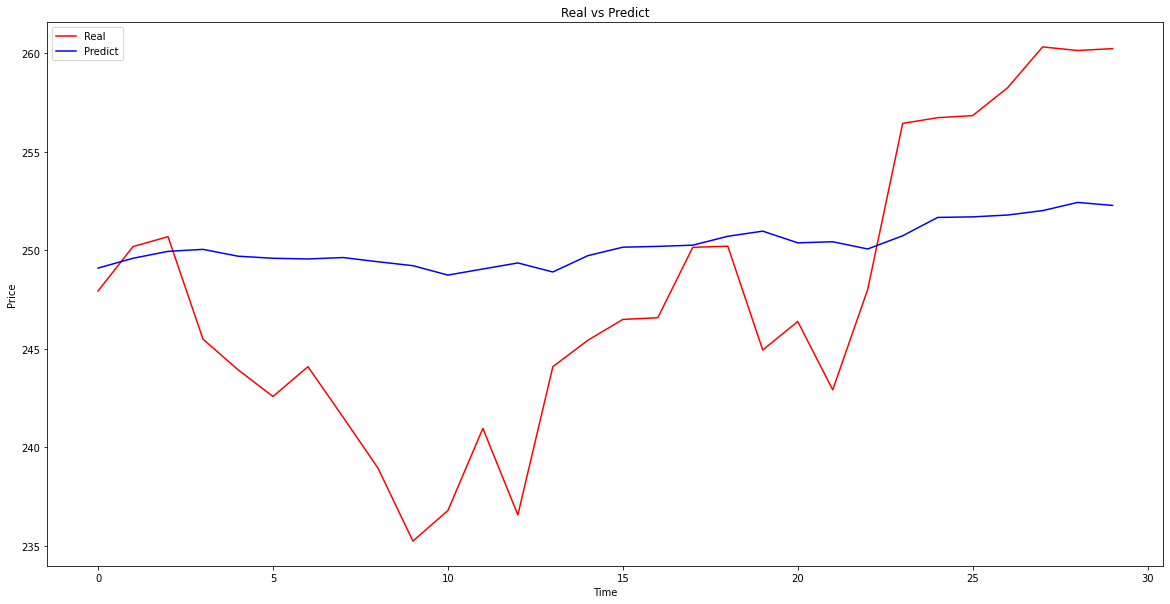

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(inv_y, color = 'red', label = 'Real')
plt.plot(inv_yhat, color = 'blue', label = 'Predict')
plt.title('Real vs Predict')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Predict Real DATA

In [98]:
#res_data=read_csv(filename=RES_PATH,folder=folder)
#res_data.columns = ('DATE','VFINX')
#res_data = res_data.fillna(method='ffill')
#res_data.head()

,DATE,VFINX
0,30/09/20,310.329987
1,29/09/20,307.779999
2,28/09/20,309.230011
3,25/09/20,304.307007
4,24/09/20,299.516418


## Y convert to Category

## Standardize Function

## SVM Classifier

## Plot Decision Boundary